# Markov chain model

In [248]:
import json
import csv
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', 500)
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import geopandas as gpd
import shapely
from shapely.geometry import Point, MultiPoint, Polygon, MultiPolygon
from shapely.affinity import scale
import matplotlib.pyplot as plt
import glob
import os
import datetime
import pytz
from pytz import timezone
import markov_scripts as m
from sklearn.metrics import mean_squared_error

## Importing and processing data

In [199]:
#Reading data; creating training and test data
df = pd.read_csv('../data/AS_price_vol.csv')
df['year'] = pd.to_datetime(df['date']).dt.year

In [200]:
df['dt'] = pd.to_datetime(df['date']+ " " + df['hr_beg'].astype(str)+ ":00")

#converting back to central time
utc = timezone('UTC')
tz = timezone('America/Chicago')
df['UTC'] = df['dt'].apply(lambda x: utc.localize(x))
df['Central'] = df['UTC'].apply(lambda x: x.astimezone(tz))
df['hr_beg'] = df['Central'].dt.hour
df['date'] = df['Central'].dt.date
df['year'] = df['Central'].dt.year

In [201]:
#manually adjusting outliers
cutoff = np.percentile(df['price_DAH_REGDN'],99.5)
df['price_DAH_REGDN'][df['price_DAH_REGDN'] > cutoff] = cutoff

In [202]:
df_test = np.array(df.loc[df['year']==2018,'price_DAH_REGDN']) #test
data = np.array(df.loc[df['year']<2018,'price_DAH_REGDN']) #training

In [203]:
#Getting hourly average
hr_avg = df[['hr_beg','price_DAH_REGDN']].groupby('hr_beg').mean()['price_DAH_REGDN'].to_dict() #useful!
df['HourlyAvg'] = df['hr_beg'].map(hr_avg)
avgs = np.array(df.loc[df['year']==2018,'HourlyAvg'])

# Markov model trained on 2008-2017 data predicting 2018 
(working to update to rolling prediction, which more realistic based on actual operations than full year at a time)

In [204]:
markovArray, cumMarkovArray, datMin, datMax, dmeshReal = m.MarkovChainFunction_24hrs(data,40)
datSim = m.MarkovSim_24hrs(df_test, cumMarkovArray, datMin, datMax, dmeshReal)

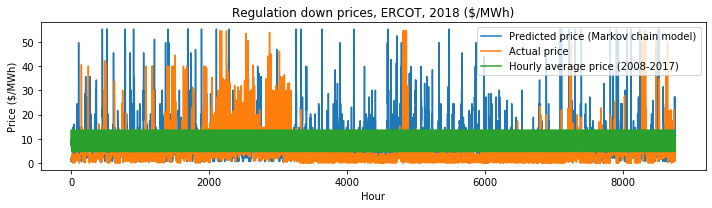

In [205]:
fig = plt.figure(figsize=(10,3))
plt.plot(datSim, label="Predicted price (Markov chain model)")
plt.plot(df_test, label="Actual price")
plt.plot(avgs, label="Hourly average price (2008-2017)")
plt.title("Regulation down prices, ERCOT, 2018 ($/MWh)")
plt.xlabel("Hour")
plt.ylabel("Price ($/MWh)")
plt.legend()
plt.tight_layout()

In [206]:
spike = np.percentile(df.loc[(df['year']<2018) & (df['year']>=2014),'price_DAH_REGDN'], 90)

In [207]:
spiking = pd.DataFrame({"actual": df_test,
                       "simulated": datSim})
spiking['both spike'] = (df_test > spike) & (datSim > spike)
len(spiking[spiking['both spike']==True]) / sum(df_test > spike)

0.1316348195329087

## Cross-validating on spike prediction

In [208]:
def spike_accuracy(y_test, y_hat, spike):
    spiking = pd.DataFrame({"actual": y_test,
                           "simulated": y_hat})
    spiking['correctly predicted spike'] = (y_test > spike) & (y_hat > spike)
    spiking['correctly predicted (spike or not)'] = (y_test < spike) & (y_hat < spike) | (y_test > spike) & (y_hat > spike)
    
    correct_spikes = len(spiking[spiking['correctly predicted spike']==True]) / sum(y_test > spike)
    correct_overall = len(spiking[spiking['correctly predicted (spike or not)']==True]) / len(y_test)
    
    return correct_spikes, correct_overall

In [209]:
#Cross-validated selection of number of bins to maximize spike prediction
bins = np.arange(10,100,5)

from sklearn.model_selection import TimeSeriesSplit

X_train = data
y_train = data
n = 5

fold = 0
tscv = TimeSeriesSplit(n_splits=n)
spike_pred = np.zeros((n,len(bins)))
overall_pred = np.zeros((n,len(bins)))

for train_index, test_index in tscv.split(X):
    X_t, X_val = X_train[train_index], X_train[test_index]
    y_t, y_val = y_train[train_index], y_train[test_index] #y_train won't get used
    
    for i, bin_num in enumerate(bins):
        markovArray, cumMarkovArray, datMin, datMax, dmeshReal = m.MarkovChainFunction_24hrs(X_t,bin_num)
        y_hat = m.MarkovSim_24hrs(X_val, cumMarkovArray, datMin, datMax, dmeshReal)
        
        correct_spikes, correct_overall = spike_accuracy(y_val, y_hat, spike=spike)
        spike_pred[fold, i] = correct_spikes
        overall_pred[fold, i] = correct_overall
    
    fold += 1

In [210]:
def make_df(spike_pred):
    spikes = pd.DataFrame(spike_pred, columns=bins)
    spikes.loc['mean',:] = spikes.mean(axis=0)
    spikes.loc['std',:] = spikes.std(axis=0)
    spikes.loc['score',:] = spikes.loc['mean',:]/spikes.loc['std',:] #normalizing scores
    avgscore = spikes.loc['score',:].replace([np.inf], np.nan).mean()
    spikes.loc['score_norm',:] = spikes.loc['score',:]/avgscore
    return spikes

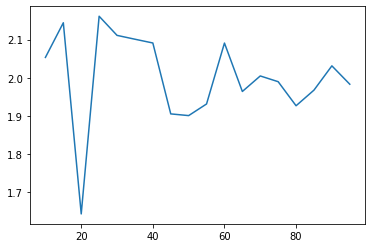

In [211]:
spikes = make_df(spike_pred)
correct = make_df(overall_pred)
real_score = correct.loc['score_norm',:] + spikes.loc['score_norm',:]
plt.plot(real_score)

In [213]:
max_spike_index = real_score.loc[25:150].idxmax()
max_spike_index #risk of overfitting if index is very high. risk of having bins be too large if index is 5 or 10. hence artificially limiting index

25

In [270]:
#Applying to actual test dataset (2018)
X_train = data
X_test = df_test #(only uses first value of the year to predict the whole year) (should really go one day at a time)
y_test = df_test
bin_num = max_spike_index

markovArray, cumMarkovArray, datMin, datMax, dmeshReal = m.MarkovChainFunction_24hrs(X_train,bin_num)
y_hat = m.MarkovSim_24hrs(X_test, cumMarkovArray, datMin, datMax, dmeshReal, rand_seed=None)
correct_spikes, correct_overall = spike_accuracy(y_test, y_hat, spike=spike)
print(correct_spikes)
print(correct_overall)

0.1464968152866242
0.8194159251654118


# Weekly restart
Captures idea that certain times of day almost always have low prices.
Seems like this dataset has too much tendency to go high--why? Daily restart is very high

In [271]:
#Applying to actual test dataset (2018)
X_train = data
X_test = df_test #(only uses first value of the year to predict the whole year) (should really go one day at a time)
y_test = df_test
bin_num = max_spike_index
markovArray, cumMarkovArray, datMin, datMax, dmeshReal = m.MarkovChainFunction_24hrs(X_train,bin_num)

In [272]:
y_hat_total = []
for i in range(53):
    y_hat = m.MarkovSim_24hrs(X_test[i*24*7:(i+1)*24*7], cumMarkovArray, datMin, datMax, dmeshReal,rand_seed=None)
    y_hat_total.extend(y_hat)

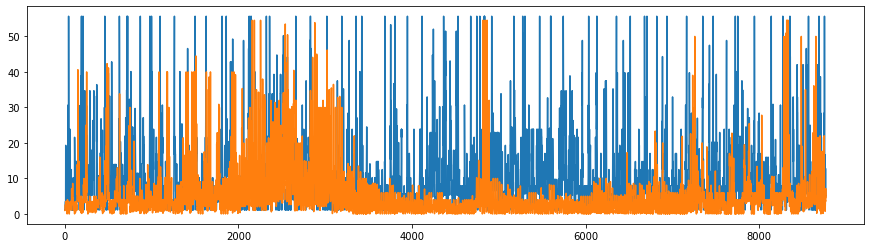

In [273]:
fig = plt.figure(figsize=(15,4))

plt.plot(y_hat_total)
plt.plot(y_test)

In [274]:
correct_spikes, correct_overall = spike_accuracy(y_test[:len(y_hat_total)], y_hat_total, spike=spike)
print(correct_spikes)
print(correct_overall)

0.21019108280254778
0.7635181382614648


# 4. Exporting results for optimization team

In [276]:
results = df.loc[df['year']==2018,['date','hr_beg']]
results.reset_index(inplace=True, drop=True)

In [277]:
results['Actual_results'] = y_test
results["Predicted_results"] = y_hat_total

In [281]:
#Dealing with DST issues
results.drop_duplicates(subset=['date','hr_beg','Actual_results'], inplace=True)

In [282]:
results.head()

,date,hr_beg,Actual_results,Predicted_results
0,2018-01-01,0,1.00,1.136458
1,2018-01-01,1,0.98,1.136458
2,2018-01-01,2,1.00,1.136458
3,2018-01-01,3,1.00,3.409375
4,2018-01-01,4,1.00,3.409375


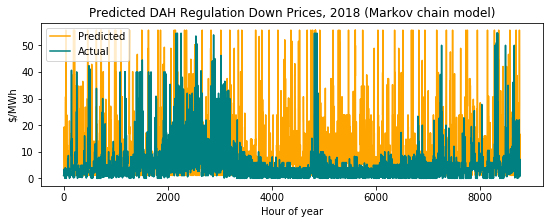

In [288]:
fig = plt.figure(figsize=(9,3))
plt.plot(results['Predicted_results'], label="Predicted", color='orange')
plt.plot(results['Actual_results'], label="Actual", color='teal')
plt.legend()
plt.title("Predicted DAH Regulation Down Prices, 2018 (Markov chain model)")
plt.xlabel('Hour of year')
plt.ylabel("$/MWh")
plt.savefig("Markov_Chain_Results.png")

results.to_csv("markov_chain_results.csv", index=False)